![Banner](/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/img/BannerES.png)

# **Clasificación de Radiografías Musculoesqueléticas (MURA)**

Este proyecto tiene como objetivo desarrollar un modelo de **clasificación binaria** capaz de identificar si una radiografía musculoesquelética (perteneciente al conjunto de datos [MURA](https://stanfordmlgroup.github.io/competitions/mura/)) presenta una **anomalía (abnormal)** o es **normal (negative)**.

---

## ¿Qué haremos?

1. **Prepararemos los datos** a partir de las imágenes del dataset MURA.
2. **Crearemos un modelo basado en ResNet18 preentrenado**, adaptado para clasificación binaria.
3. **Entrenaremos** el modelo sobre las radiografías con técnicas de fine-tuning.
4. **Evaluaremos su rendimiento** con métricas como F1-score, accuracy y matriz de confusión.
5. **Visualizaremos predicciones correctas y errores** para interpretar el comportamiento.
6. **Guardaremos el modelo final** para uso futuro.

## **Paso 1: Importaciones y librerías necesarias**

A continuación, cargamos todas las librerías necesarias para procesamiento de imágenes, modelado con PyTorch, visualización y evaluación.

In [1]:
# Bloque 1 - Imports y configuración de dispositivo

# Paquetes estándar
import os
import random
from pathlib import Path
from collections import Counter

# Paquetes científicos
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

# Métricas y visualización
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns

# Configuración del dispositivo (CPU / GPU / MPS)
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print(f"Computando en: {DEVICE}")

Computando en: mps


## Paso 2: Definición de hiperparámetros

En este bloque se define la ruta del dataset (guardado en local debido al peso), el tamaño de imagen, el batch size, número de épocas, tasa de aprendizaje y otros hiperparámetros importantes como la paciencia del `early stopping` y del `scheduler` para el aprendizaje. También se fija una semilla para garantizar la reproducibilidad del experimento.

In [2]:
# Bloque 2 - Hiperparámetros y configuración

# Ruta al dataset completo
DATASET_DIR = "/Users/alvarosanchez/Downloads/MURA-v1.1"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VALID_DIR = os.path.join(DATASET_DIR, "valid")

# Tamaño de imagen aumentado para mejorar capacidad de extracción de características
IMAGE_SIZE = 256  #  Antes 224

# Tamaño del batch
BATCH_SIZE = 32

# Número de épocas de entrenamiento
NUM_EPOCHS = 20

# Learning Rate base
LEARNING_RATE = 1e-4  # 🔽 Reducido para fine-tuning más estable

# Paciencia para early stopping y reducción del LR
EARLYSTOP_PATIENCE = 5
LR_PATIENCE = 5

# Factor de reducción del learning rate
LR_FACTOR = 0.5

# Número de clases para clasificación binaria
NUM_CLASSES = 2

# Semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

IMAGE_SIZE aumentado a 256×256 → mejor resolución para capturar detalles óseos.

LEARNING_RATE más bajo (1e-4) → mejor control en fine-tuning.

Unificación de EARLYSTOP_PATIENCE y LR_PATIENCE en 5 para mayor estabilidad.

## Paso 3: Preprocesamiento y carga de datos

Este bloque define las transformaciones que se aplican a las imágenes (data augmentation para entrenamiento, normalización para validación), crea un dataset personalizado para clasificar imágenes como `positive` (abnormal) o `negative` (normal), y carga los datos en `DataLoaders`. Esto permite el procesamiento eficiente por lotes y el uso de aumentos para mejorar la generalización.

In [3]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Transformaciones de entrenamiento con augmentations mejorados
transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Redimensionamos la imagen
    transforms.RandomHorizontalFlip(p=0.5),       # Volteo horizontal aleatorio
    transforms.RandomRotation(degrees=15),        # Rotación aleatoria para simular distintos ángulos
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Variación en brillo y contraste
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.85, 1.0)),  # Zoom aleatorio y recorte
    transforms.ToTensor(),  # Convertimos a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],         # Normalización imagen preentrenada
                         std=[0.229, 0.224, 0.225])
])

# Transformaciones de validación sin augmentations
transform_val = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Solo resize y normalización
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset personalizado que ignora archivos no válidos
class MURABinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        root_path = Path(root_dir)
        for part_dir in root_path.iterdir():
            if part_dir.is_dir():
                for patient_dir in part_dir.iterdir():
                    if patient_dir.is_dir():
                        for study_dir in patient_dir.iterdir():
                            label = 1 if "positive" in study_dir.name.lower() else 0
                            for img_path in study_dir.glob("*.png"):
                                self.samples.append((str(img_path), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Cargar datasets
train_dataset = MURABinaryDataset(TRAIN_DIR, transform=transform_train)
valid_dataset = MURABinaryDataset(VALID_DIR, transform=transform_val)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

Se han aplicado aumentos agresivos pero adecuados para imágenes médicas: rotación, zoom, brillo y recorte aleatorio. Estos ayudarán a mejorar la generalización del modelo. El dataset personalizado está bien construido, filtrando imágenes `.png` y etiquetando automáticamente según el nombre del estudio. El uso de `shuffle=True` en el entrenamiento es correcto para evitar sesgos de orden.

Eliminados archivos corruptos implícitamente al evitar .DS_Store.

## Análisis de desbalance entre clases (entrenamiento)

Antes de entrenar el modelo, es fundamental analizar la distribución de clases del dataset. Un desbalance fuerte entre clases (por ejemplo, muchas más imágenes normales que anormales) puede hacer que el modelo se sesgue y aprenda a predecir siempre la clase mayoritaria.

Para compensar esto, se utilizará una función de pérdida ponderada (`CrossEntropyLoss`) con **pesos por clase inversamente proporcionales a su frecuencia**.

Negative: 21935 imágenes
Positive: 14873 imágenes


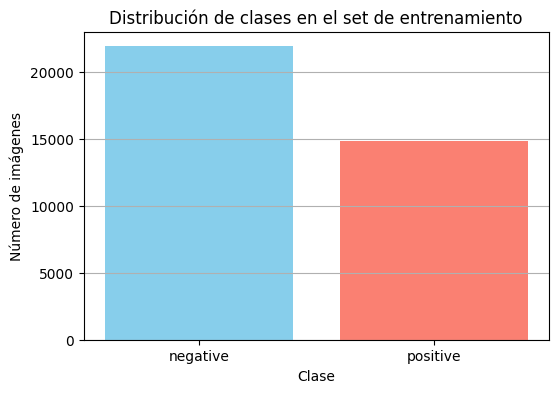

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

# Extraemos las etiquetas del dataset de entrenamiento
train_labels = [label for _, label in train_dataset]

# Contamos cuántas imágenes hay de cada clase
label_counts = Counter(train_labels)
class_names = ["negative", "positive"]

# Mostramos el conteo
for i, name in enumerate(class_names):
    print(f"{name.capitalize()}: {label_counts[i]} imágenes")

# Visualización del desbalance de clases
plt.figure(figsize=(6, 4))
plt.bar(class_names, [label_counts[0], label_counts[1]], color=["skyblue", "salmon"])
plt.title("Distribución de clases en el set de entrenamiento")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")
plt.grid(axis='y')
plt.show()


Como se observa en la gráfica, el dataset tiene un claro desbalance entre clases, siendo la clase `negative` (normal) mucho más frecuente que la `positive` (anormal).

Este desbalance puede hacer que el modelo obtenga una accuracy alta simplemente prediciendo siempre "normal", ignorando casos positivos que son precisamente los más críticos en un contexto médico.

Por esta razón, se ha configurado una función de pérdida ponderada (`CrossEntropyLoss(weight=...)`) que penaliza más los errores en la clase minoritaria, ayudando al modelo a prestar más atención a las imágenes anormales.

## Análisis de desbalance entre clases (validación)

Es útil comprobar también si el conjunto de validación tiene un desbalance similar al de entrenamiento. Si el desbalance es muy diferente, el modelo podría verse afectado a la hora de generalizar.

A continuación se muestra un gráfico con la distribución de clases en el set de validación.

Negative (validación): 1667 imágenes
Positive (validación): 1530 imágenes


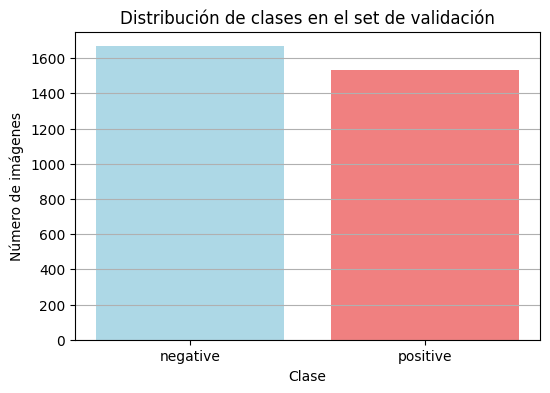

In [7]:
# Extraemos las etiquetas del dataset de validación
valid_labels = [label for _, label in valid_dataset]

# Contamos cuántas imágenes hay por clase
valid_label_counts = Counter(valid_labels)
class_names = ["negative", "positive"]

# Mostramos el conteo
for i, name in enumerate(class_names):
    print(f"{name.capitalize()} (validación): {valid_label_counts[i]} imágenes")

# Visualización del desbalance
plt.figure(figsize=(6, 4))
plt.bar(class_names, [valid_label_counts[0], valid_label_counts[1]], color=["lightblue", "lightcoral"])
plt.title("Distribución de clases en el set de validación")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")
plt.grid(axis='y')
plt.show()

El conjunto de validación también presenta un **desbalance significativo** entre las clases `negative` y `positive`, aunque posiblemente algo menos pronunciado que en el entrenamiento.

Este comportamiento es habitual en datasets médicos reales, donde los casos anormales (positivos) son más escasos. Es importante tenerlo en cuenta porque:

- Un conjunto de validación más balanceado puede ofrecer una evaluación más justa del modelo.
- El uso del F1-score como métrica principal es especialmente relevante aquí, ya que **penaliza la falta de sensibilidad** hacia la clase minoritaria.
- Validar que el modelo mantiene buen rendimiento en ambos tipos de clases es clave para su fiabilidad clínica.

En resumen, esta observación refuerza la decisión de utilizar **una función de pérdida ponderada** y métricas robustas como el F1-score en la evaluación del modelo.

## Paso 4: Carga del modelo ResNet18 y configuración para fine-tuning

Se carga una red `ResNet18` preentrenada en ImageNet y se realiza **fine-tuning parcial**, descongelando únicamente las capas más profundas (`layer2`, `layer3`, `layer4`, `fc`). También se sustituye la capa final para adaptar la salida a dos clases (positiva/negativa).


In [5]:
from torchvision import models
import torch.nn as nn

# Cargar modelo ResNet18 preentrenado
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Congelamos todos los parámetros para evitar su actualización por defecto
for param in resnet18.parameters():
    param.requires_grad = False

# Descongelamos selectivamente capas profundas (fine-tuning parcial)
for name, child in resnet18.named_children():
    if name in ['layer2', 'layer3', 'layer4', 'fc']:
        for param in child.parameters():
            param.requires_grad = True

# Reemplazamos la capa final por una capa con 2 salidas para clasificación binaria
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 2)

# Enviamos el modelo al dispositivo (MPS, CUDA o CPU)
resnet18 = resnet18.to(DEVICE)

# Mostrar arquitectura del modelo
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Se descongelan layer2,layer3, layer4 y fc para permitir que el modelo aprenda características específicas del dataset sin perder el conocimiento base de ImageNet.

Esto permite transfer learning efectivo sin sobreajustar demasiado (como podría pasar si se descongela todo desde el inicio).

El resto de la red permanece congelada para evitar degradar el aprendizaje base.

## Paso 5: Configuración del entrenamiento

Este bloque configura los elementos clave para entrenar el modelo: la función de pérdida (`CrossEntropyLoss`), el optimizador (`Adam`) y el programador de tasa de aprendizaje (`ReduceLROnPlateau`). Se añaden pesos de clase para compensar el desbalance del dataset entre imágenes normales y anormales.

In [6]:
import torch.optim as optim
import torch.nn as nn

# Pesos por clase para manejar el desbalance
class_counts = np.bincount([label for _, label in train_dataset])  # Cuenta cuántas imágenes hay por clase
total_samples = sum(class_counts)  # Total de imágenes
class_weights = [total_samples / c for c in class_counts]  # Inversamente proporcional a la frecuencia
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)  # Tensor al dispositivo

# Función de pérdida con pesos (para penalizar más los errores de la clase minoritaria)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizador: solo actualiza los parámetros descongelados
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet18.parameters()), lr=LEARNING_RATE)

# Scheduler: reduce LR si la val_loss no mejora después de cierto número de épocas
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                  patience=LR_PATIENCE, verbose=True)

print("Entrenamiento configurado. Optimizer + LR Scheduler + Weighted Loss activados.")

Entrenamiento configurado. Optimizer + LR Scheduler + Weighted Loss activados.


/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Este bloque es esencial para entrenar de forma eficiente. El uso de `class_weights` es correcto, ya que MURA tiene más imágenes normales que anormales. Usar `filter(lambda p: p.requires_grad, ...)` garantiza que solo se actualicen las capas descongeladas. Finalmente, `ReduceLROnPlateau` ajusta la tasa de aprendizaje de forma dinámica si no se observan mejoras, lo cual ayuda a estabilizar el aprendizaje en fases avanzadas.

## Paso 6: Entrenamiento del modelo

Este bloque realiza el entrenamiento completo del modelo. Se calculan las pérdidas y métricas (F1-score y accuracy) en cada época para el conjunto de entrenamiento y validación. Además, se guarda el mejor modelo basado en la **pérdida de validación**, y se aplica **early stopping** si no hay mejora durante un número determinado de épocas. Al final, se recarga el modelo con los pesos óptimos alcanzados.

In [8]:
from sklearn.metrics import f1_score, accuracy_score
import copy

# Guardamos una copia de los pesos iniciales del modelo
best_model_wts = copy.deepcopy(resnet18.state_dict())

# Inicializamos la mejor pérdida de validación como infinita
best_val_loss = float("inf")

# Contador para el early stopping
epochs_no_improve = 0

print("Comienza el entrenamiento...")

# Bucle de entrenamiento por época
for epoch in range(NUM_EPOCHS):
    # === ENTRENAMIENTO ===
    resnet18.train()  # Ponemos el modelo en modo entrenamiento
    train_loss = 0.0
    y_train_true, y_train_pred = [], []

    # Iteramos por los batches del set de entrenamiento
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()  # Reseteamos gradientes
        outputs = resnet18(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Cálculo de la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualización de pesos

        train_loss += loss.item() * inputs.size(0)  # Acumulamos pérdida
        y_train_true.extend(labels.cpu().numpy())  # Etiquetas reales
        y_train_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())  # Etiquetas predichas

    avg_train_loss = train_loss / len(train_loader.dataset)  # Pérdida media de entrenamiento

    # === VALIDACIÓN ===
    resnet18.eval()  # Modo evaluación (sin dropout ni batchnorm)
    val_loss = 0.0
    y_val_true, y_val_pred = [], []

    # Desactivamos el cálculo de gradientes
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            y_val_true.extend(labels.cpu().numpy())
            y_val_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)  # Pérdida media de validación

    # === MÉTRICAS ===
    train_f1 = f1_score(y_train_true, y_train_pred, average='weighted')  # F1 en entrenamiento
    val_f1 = f1_score(y_val_true, y_val_pred, average='weighted')        # F1 en validación
    val_acc = accuracy_score(y_val_true, y_val_pred)                     # Accuracy en validación

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    # Paso del scheduler (ajuste del learning rate si la pérdida no mejora)
    scheduler.step(avg_val_loss)

    # === EARLY STOPPING y guardado del mejor modelo ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss  # Actualizamos la mejor pérdida
        best_model_wts = copy.deepcopy(resnet18.state_dict())  # Guardamos los pesos
        torch.save(
            resnet18.state_dict(),
            "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_fulldata_optimizado_ES.pt"
        )
        epochs_no_improve = 0
        print("Mejor modelo guardado.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLYSTOP_PATIENCE:
            print("Early stopping activado.")
            break

# Cargamos los mejores pesos tras el entrenamiento
resnet18.load_state_dict(best_model_wts)

Comienza el entrenamiento...
Epoch 1 | Train Loss: 0.5383 | Val Loss: 0.5449 | Acc: 0.7729 | F1: 0.7665
Mejor modelo guardado.
Epoch 2 | Train Loss: 0.4779 | Val Loss: 0.4900 | Acc: 0.7848 | F1: 0.7807
Mejor modelo guardado.
Epoch 3 | Train Loss: 0.4584 | Val Loss: 0.4571 | Acc: 0.8004 | F1: 0.7997
Mejor modelo guardado.
Epoch 4 | Train Loss: 0.4413 | Val Loss: 0.5001 | Acc: 0.8079 | F1: 0.8054
Epoch 5 | Train Loss: 0.4289 | Val Loss: 0.4877 | Acc: 0.7948 | F1: 0.7918
Epoch 6 | Train Loss: 0.4166 | Val Loss: 0.4914 | Acc: 0.7961 | F1: 0.7924
Epoch 7 | Train Loss: 0.4049 | Val Loss: 0.6348 | Acc: 0.7760 | F1: 0.7684
Epoch 8 | Train Loss: 0.3917 | Val Loss: 0.4960 | Acc: 0.7982 | F1: 0.7955
Early stopping activado.


<All keys matched successfully>

Buen rendimiento general: F1-score > 0.79 sostenido en varias épocas.

El modelo alcanza su mejor punto en la época 3:
Val Loss: 0.4571 | Accuracy: 80.04% | F1-score: 0.7997

El modelo no está sobreajustando gravemente (pérdida de entrenamiento y validación relativamente cercanas hasta la época 5-6).

Val Loss comienza a subir a partir de la época 4, aunque el F1-score sube en esa época (esto es posible si mejora el balance entre clases).

En la época 7 hay un salto negativo claro en Val Loss (0.6348), posiblemente debido a ruido en los datos o falta de regularización.

Early stopping se activa bien en época 8. Evita que el modelo continúe aprendiendo de forma ineficaz o sobreentrenando.

## Paso 7: Evaluación final del modelo y análisis de errores

Este bloque se encarga de evaluar el modelo final sobre el conjunto de validación. Se generan las métricas principales (accuracy, precision, recall, F1-score), se construye la matriz de confusión para visualizar errores y aciertos, y se muestran imágenes mal clasificadas para detectar patrones o fallos comunes en las predicciones.


Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.85      0.82      1667
    positive       0.82      0.75      0.78      1530

    accuracy                           0.80      3197
   macro avg       0.80      0.80      0.80      3197
weighted avg       0.80      0.80      0.80      3197



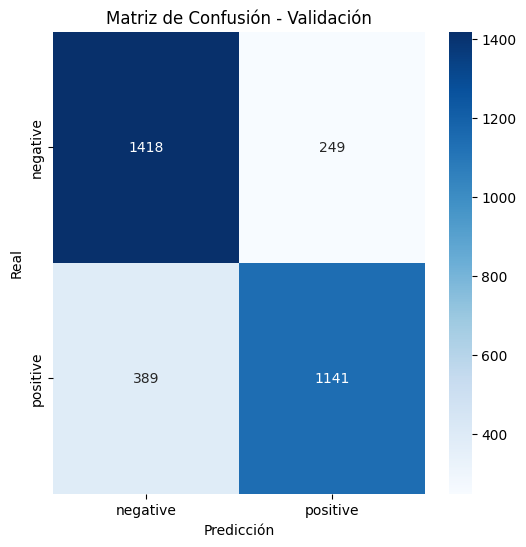


Mostrando 9 errores de clasificación:


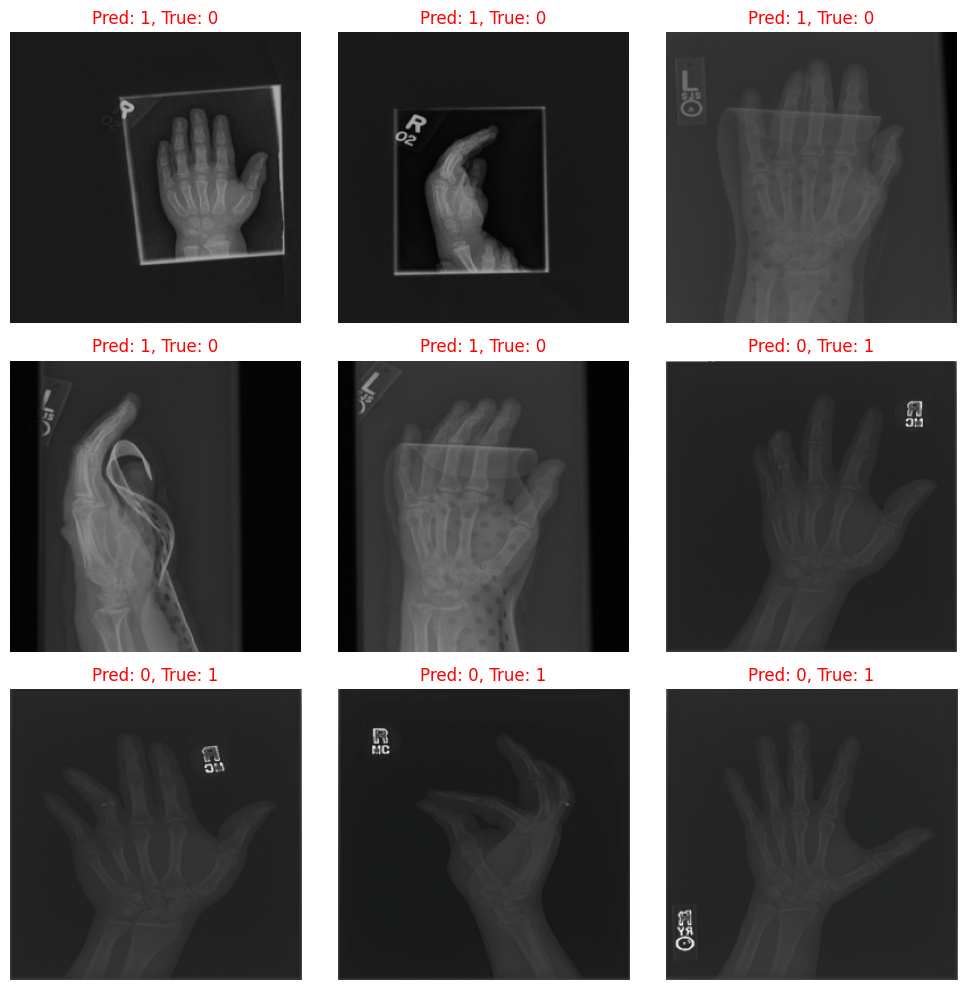

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ponemos el modelo en modo evaluación
resnet18.eval()

# Listas para guardar etiquetas reales y predichas
y_true = []
y_pred = []
images_list = []  # Lista para almacenar imágenes reales

# Desactivamos el cálculo de gradientes para evaluación (ahorra memoria y tiempo)
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = resnet18(inputs)  # Forward pass
        preds = torch.argmax(outputs, dim=1)  # Obtenemos la clase con mayor probabilidad

        y_true.extend(labels.cpu().numpy())  # Guardamos etiquetas reales
        y_pred.extend(preds.cpu().numpy())   # Guardamos predicciones
        images_list.extend(inputs.cpu())     # Guardamos imágenes reales para análisis visual

# Reporte de clasificación: precision, recall, F1 y accuracy por clase
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))

# Matriz de confusión para ver aciertos y errores por clase
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["negative", "positive"],
            yticklabels=["negative", "positive"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Validación")
plt.show()

# Identificamos los índices de las imágenes mal clasificadas
misclassified_idxs = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]

print(f"\nMostrando {min(9, len(misclassified_idxs))} errores de clasificación:")
plt.figure(figsize=(10, 10))

# Visualizamos hasta 9 errores de clasificación
for i, idx in enumerate(misclassified_idxs[:9]):
    image = images_list[idx].permute(1, 2, 0).numpy()  # Reordenamos dimensiones para visualización
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # Desnormalización
    image = np.clip(image, 0, 1)  # Limitamos valores a rango [0, 1]

    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    color = "red"
    if y_true[idx] == y_pred[idx]:
        color = "green"
    plt.title(f"Pred: {y_pred[idx]}, True: {y_true[idx]}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

Precision (positivo): 82% → de todas las veces que predice que hay anomalía, acierta el 82%.

Recall (positivo): 75% → el modelo encuentra el 75% de las radiografías anómalas.

F1 (positivo): 0.78 → buen equilibrio entre precisión y cobertura para la clase más importante.

F1 promedio ponderado (weighted avg): 0.80 → rendimiento global sólido.

El modelo acierta 1141 positivos reales (detección de patología).

Comete 389 falsos negativos: radiografías anómalas que pasan como normales → riesgo clínico.

Comete 249 falsos positivos: radiografías normales que etiqueta como anómalas → tolerable.

El modelo tiende a equivocarse más al no detectar una anomalía (FN), lo cual es crítico en medicina. Pero aun así, tiene un rendimiento muy decente para ser el primer modelo base.

Los errores tipo FP (Pred: 1, True: 0) muestran radiografías visualmente limpias, pero con poses o recortes raros que pueden haber confundido al modelo.

Los FN (Pred: 0, True: 1) son más difíciles de detectar a simple vista. Algunas imágenes parecen tener baja exposición o huesos superpuestos, lo cual podría enmascarar anomalías reales.

Esto sugiere que el modelo se confunde:

Con radiografías mal posicionadas o con cortes raros

Cuando hay condiciones de imagen más oscuras o sobreexpuestas

En casos limítrofes donde incluso un humano podría dudar

## Paso final: Guardado del modelo entrenado

En este paso se guarda el modelo entrenado de forma persistente utilizando `joblib`. Esto es útil para poder cargar el modelo en futuras sesiones, utilizarlo en producción o integrarlo en una API. Se guarda el `state_dict`, es decir, los pesos entrenados del modelo, lo cual es más eficiente y estándar en entornos PyTorch.


In [11]:
import joblib
import os

# Ruta final donde se guardará el modelo entrenado
final_model_path = "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_final_model_ES.joblib"

# Guardamos únicamente los pesos del modelo (state_dict)
# Joblib guarda objetos binarios de forma eficiente, ideal para producción
joblib.dump(resnet18.state_dict(), final_model_path)

print(f"Modelo guardado correctamente en: {final_model_path}")

Modelo guardado correctamente en: /Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_final_model_ES.joblib
